<h1 style="text-align: center;">Projet SVM - Classification d'objets célestes </h1>

---



Ce projet a pour objectif de construire des modèles de classification, notamment un Support Vector Machine (SVM), afin de distinguer différents types d’objets célestes à partir de données issues du Sloan Digital Sky Survey (SDSS), que l’on peut traduire par Relevé numérique du ciel Sloan.

Le SDSS est un vaste programme d’observation astronomique lancé en 2000. Il utilise un télescope optique dédié de 2,5 mètres de diamètre, installé à l’observatoire d’Apache Point, situé au Nouveau-Mexique, aux États-Unis. Ce projet a permis de collecter des données photométriques et spectroscopiques sur des millions d’objets dans l’univers, ce qui en fait une base idéale pour des projets d’analyse et de machine learning.

Nous utilisons ici le dataset disponible sur Kaggle : [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

## Description du dataset

Le jeu de données utilisé contient environ 100 000 observations d’objets célestes, chacun étant classé selon son type spectral (étoile, galaxie, quasar). Il regroupe deux types principaux de données :

- **Photométriques** : ce sont des mesures de la lumière émise par les objets dans différentes bandes de longueurs d’onde (`u`, `g`, `r`, `i`, `z`). Elles permettent d’évaluer la luminosité et la couleur des objets.

- **Spectroscopiques** : elles proviennent de l’analyse du spectre de lumière, et incluent notamment le redshift (décalage vers le rouge), utile pour estimer la distance et la vitesse d’un objet.


### Objectif de la classification

L'objectif principal de ce projet est de prédire le type d'objet céleste à partir des différentes caractéristiques observées. La *variable cible* dans le dataset est la colonne `class`, qui indique la nature de l'objet. Cette colonne prend l'une des trois valeurs suivantes :

- `STAR` : désigne une étoile, un corps céleste composé principalement d'hydrogène et d'hélium, qui produit de la lumière par fusion nucléaire. Les étoiles sont souvent proches (à l’échelle cosmique) et nombreuses dans le ciel.
  
- `GALAXY` : fait référence à une galaxie, un ensemble gigantesque de milliards d’étoiles, de gaz, de poussières et de matière noire. Ce sont des structures lointaines, bien plus grandes que les étoiles individuelles.

- `QSO` *(Quasi-Stellar Object)* : ce sont les quasars, des objets extrêmement lumineux situés au centre de certaines galaxies, alimentés par un trou noir supermassif. Ils ressemblent à des étoiles sur les images mais ont un comportement énergétique très différent.

Le but est donc de construire un modèle capable de distinguer automatiquement ces trois types d’objets.

### Description des variables explicatives

| Colonne         | Description |
|------------------|-------------|
| `obj_ID`         | Identifiant unique de l'objet |
| `alpha`          | Ascension droite - coordonnée céleste équivalente à la longitude |
| `delta`          | Déclinaison - équivalent de la latitude céleste |
| `u`, `g`, `r`, `i`, `z` | Magnitudes apparentes - intensité lumineuse mesurée dans différentes bandes de longueurs d'onde (5) |
| `run_ID`         | Identifiant de la session d'observation |
| `rerun_ID`       | Version du traitement de données |
| `cam_col`        | Couleur du canal utilisé pour l'observation |
| `field_ID`       | Identifiant du champ du ciel observé |
| `spec_obj_ID`    | Identifiant de l’objet en spectroscopie |
| `redshift`       | Déplacement vers le rouge, indicateur de distance ou de vitesse |
| `plate`, `MJD`, `fiber_ID` | Détails techniques de l'observation spectroscopique (3) |


## But de notre étude

Nous allons entraîner différents modèles afin deprédire la colonne `class` à partir des autres variables.  
Nous passerons par plusieurs étapes :

1. Analyse exploratoire des données (EDA)
2. Prétraitement
3. Entraînement des modèles et évaluation des performances
4. Choix du meilleur modèle
5. Conclusion




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Chargement du jeu de données
df = pd.read_csv("star_classification.csv")

## 1. Analyse exploratoire des données (EDA)

### 1.1. Analyse initiale des données

- Affichage des premières lignes du dataset

In [3]:
print("Aperçu des données :")
df.head()

Aperçu des données :


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


- Statistiques descriptives

In [6]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


- Information sur les types des données

In [7]:
print("\nInformations sur les données :")
df.info()


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64 

- Détections de valeurs manquantes (NA)

In [8]:
print("\nValeurs manquantes :")
print(df.isnull().sum())


Valeurs manquantes :
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


Le jeu de données ne contient aucune valeur manquante

- Distribution des classes

In [9]:
print("\nRépartition des classes :")
print(df['class'].value_counts())


Répartition des classes :
class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


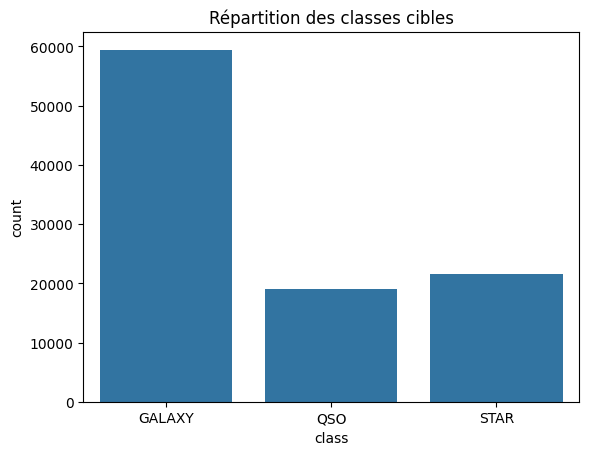

In [10]:
# Visualisation de la distribution des classes
sns.countplot(x='class', data=df)
plt.title("Répartition des classes cibles")
plt.show()

Le jeu de données est modérément déséquilibré, avec GALAXY en classe majoritaire, mais également une classe minoritaire importante (QSO). Cela peut poser un problème pour l'entraînement de certains modèles, car ils peuvent être biaisés vers la classe majoritaire, négligeant ainsi les classes minoritaires comme QSO. Il conviendra donc de traiter ces points avant l'estimation des modèles.

- Encodage de la variable cible "class"

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

#df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

La variable cible a été encodée afin de la rendre compatible avec les algorithmes de ML

- Répartition des classes après encodage

In [5]:
print("\nRépartition des classes :")
print(df['class'].value_counts())


Répartition des classes :
class
0    59445
2    21594
1    18961
Name: count, dtype: int64


- Détection des outliers

In [13]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df) 
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()
len(outlier_index)

15256

15 256 outliers représente environ 15% du jeu de données. Dans un contexte de données astronomiques, les outliers ne sont pas nécessairement des erreurs mais peuvent représenter des objets rares et scientifiquement pertinents, comme des quasars ou des galaxies atypiques. Les supprimer risquerait d'introduire un biais , notamment vis-à-vis des classes minoritaires, alors qu’un SVM bien réglé peut tolérer ces points extrêmes sans en être trop affecté. C'est pourquoi nous décidons de les conserver pour la suite de l'analyse.

### 1.2 Analyse univariée

- Visualisation de la répartiton des classes de la variable cible

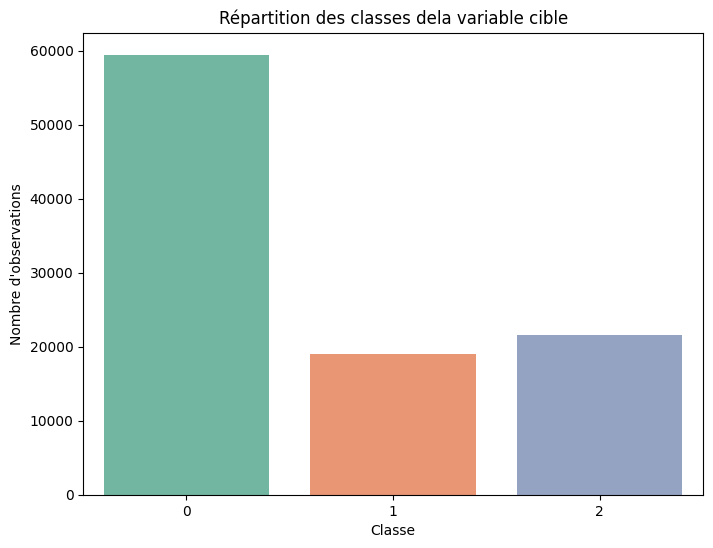

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='Set2')
plt.title('Répartition des classes dela variable cible')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

- Visualisation de la distribution des variables numériques

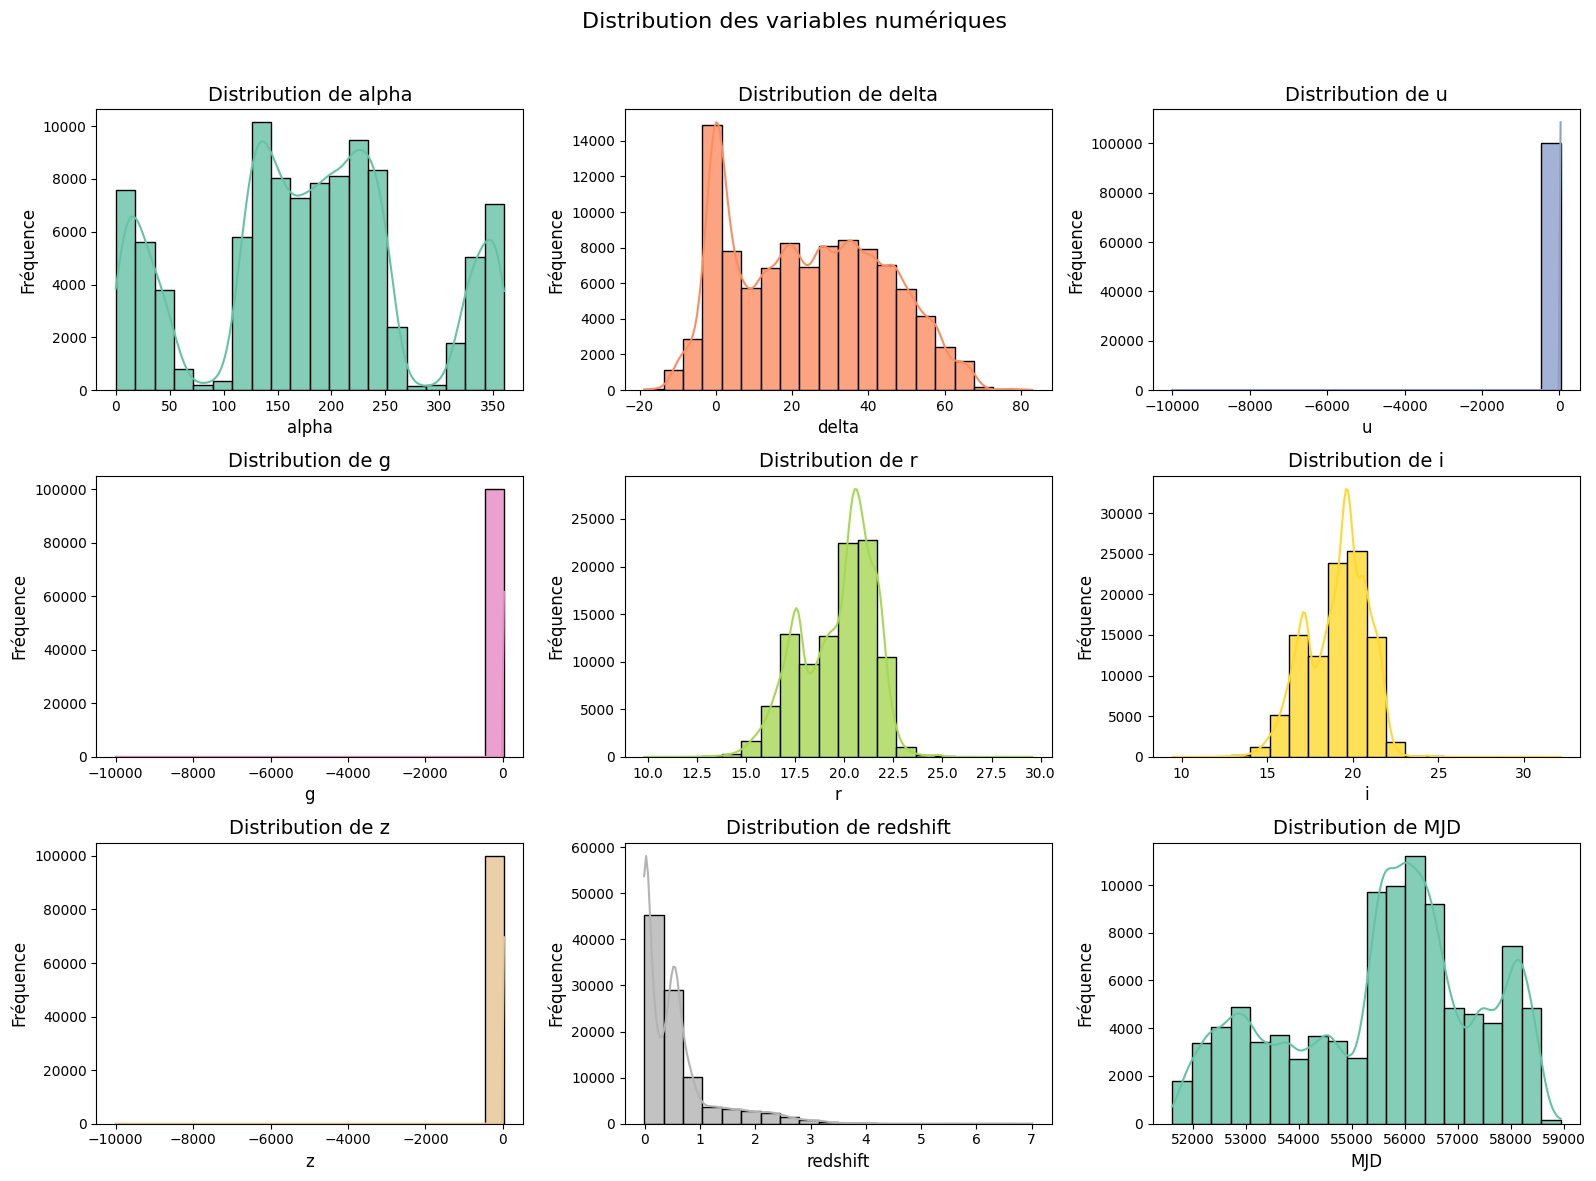

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

numeriques = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']

colors = sns.color_palette("Set2", n_colors=len(numeriques))

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, feature in enumerate(numeriques):
    ax = axes[i // 3, i % 3]
    
    sns.histplot(
        df[feature],
        bins=20,
        kde=True,
        color=colors[i],
        edgecolor='black',
        ax=ax,
        alpha=0.8
    )
    
    ax.set_title(f'Distribution de {feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Fréquence', fontsize=12)

plt.suptitle('Distribution des variables numériques', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



La plupart des variables semblent bien distribuées, sauf quelques-unes qui montrent des valeurs extrêmes (notamment g, u, z avec des valeurs très négatives).

redshift est très asymétrique, ce qui peut influencer les modèles sensibles à la normalité.

r et i ont des distributions assez proches et concentrées, ce qui peut indiquer une forte corrélation.

### 1.3. Analyse bivariée

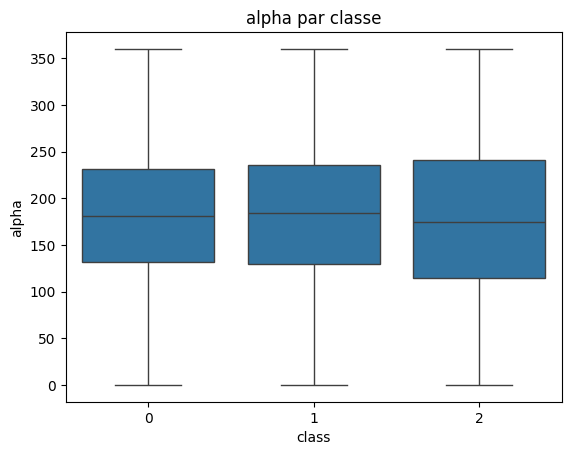

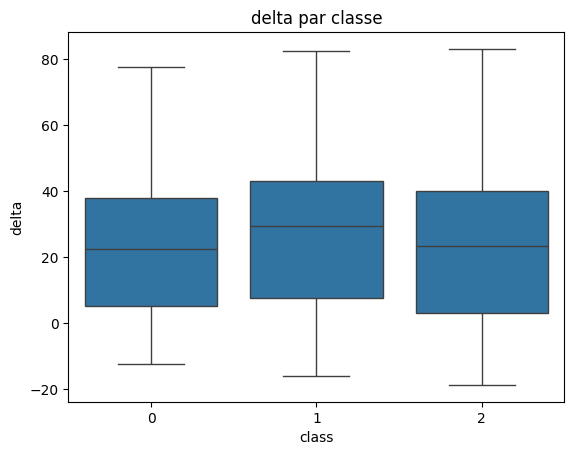

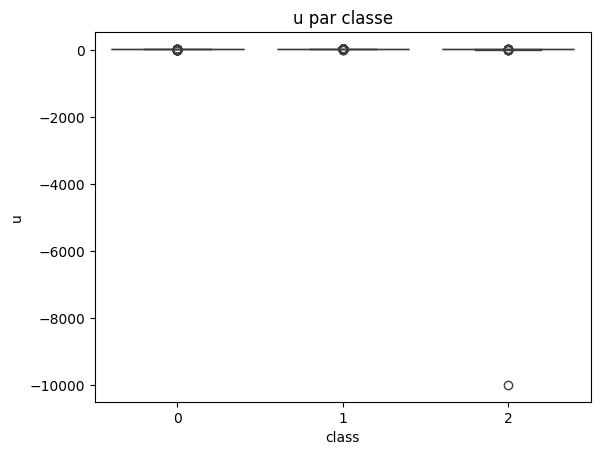

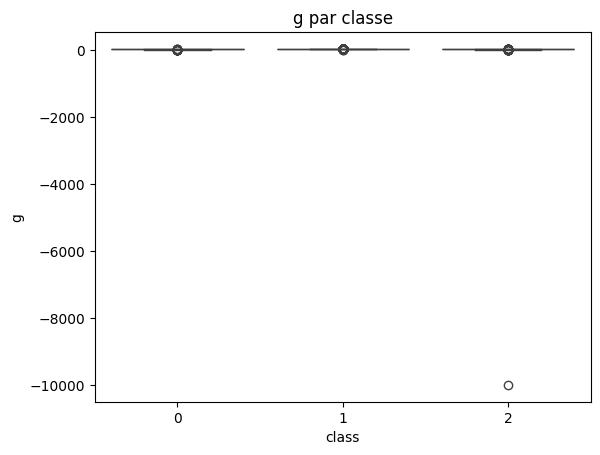

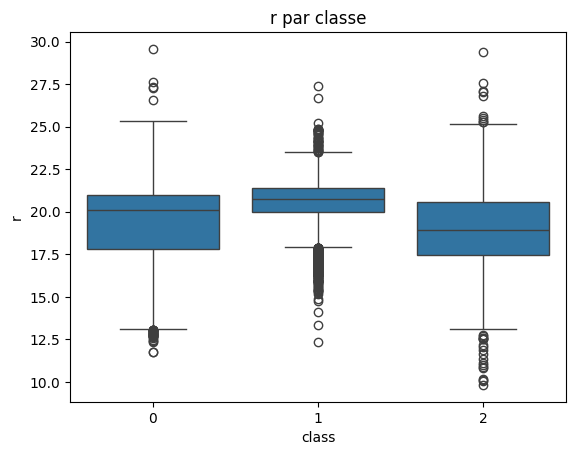

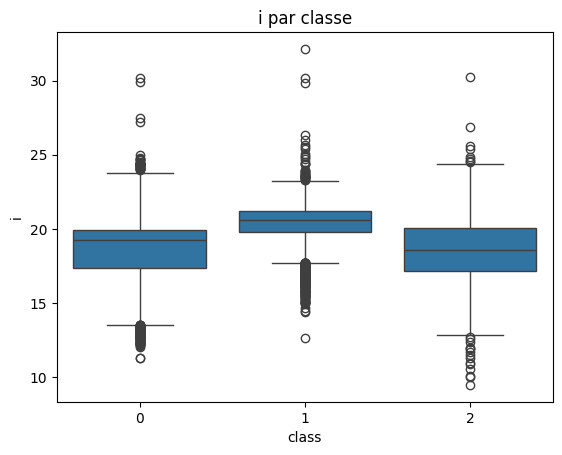

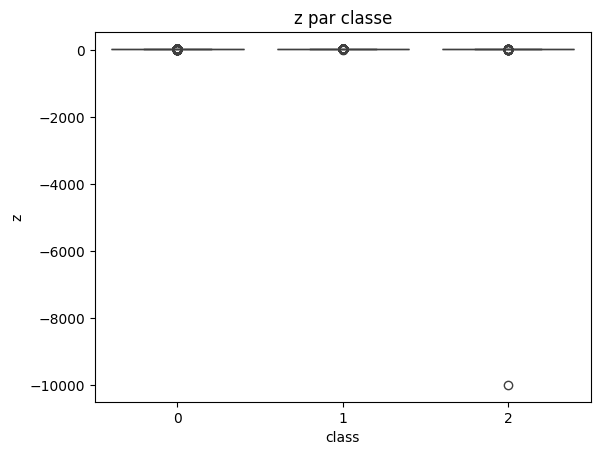

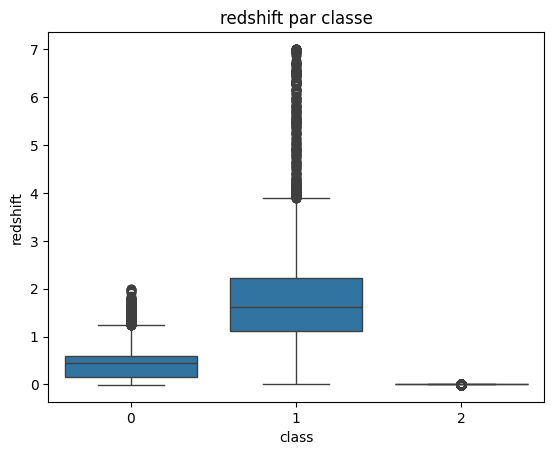

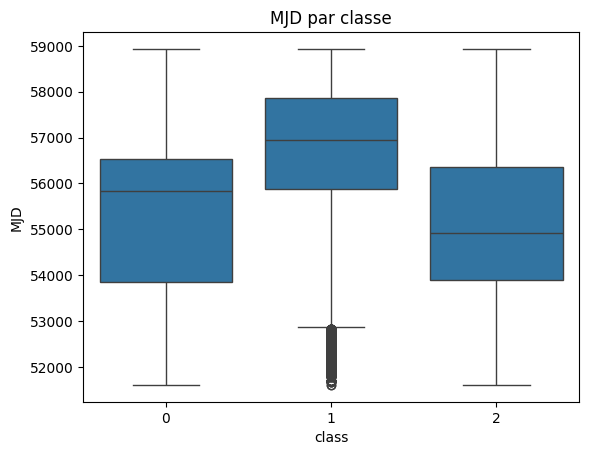

In [19]:
for col in numeriques:
    sns.boxplot(x='class', y=col, data=df)
    plt.title(f'{col} par classe')
    plt.show()

- Matrice de corrélation

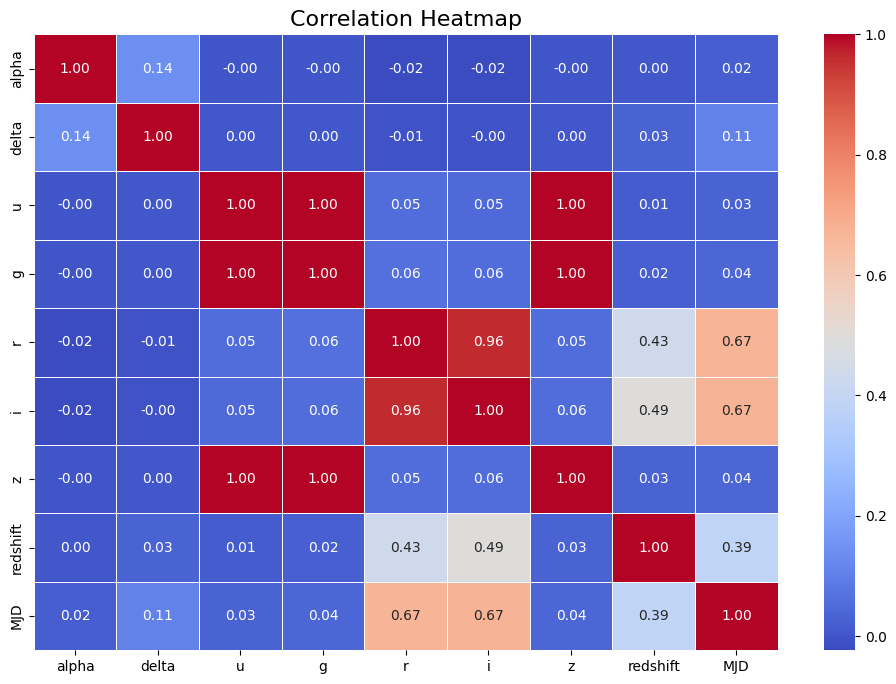

In [20]:
# Matrice de corrélation entre les variables numériques
corr_matrix = df[numeriques].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Très forte corrélation entre r et i (0.96) 

MJD est moyennement corrélée avec r, i (≈ 0.67) 

Le reste des variables ne présentent pas de corrélations très fortes 

In [21]:
corr = df.corr()
corr["class"].sort_values()

r             -0.076766
redshift      -0.054239
fiber_ID      -0.041586
run_ID        -0.036014
obj_ID        -0.036012
field_ID      -0.034833
u             -0.024645
g             -0.020066
alpha         -0.011756
spec_obj_ID   -0.010060
plate         -0.010060
z             -0.001614
MJD           -0.000405
delta          0.014452
i              0.015028
cam_col        0.023138
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

## 2. Prétraitement des données

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

- Suppression de la colonne cible "class" pour les variables explicatives

In [6]:
x = df.drop('class', axis=1)
y = df['class']

- Traitement du déséquilibre entre les classes avec SMOTE

In [9]:
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 2: 21594, 1: 18961})
Resampled dataset shape Counter({0: 59445, 1: 59445, 2: 59445})


Le jeu de données initial étant déséquilibré entre les classes, il a été rééchantillonné pour assurer une répartition équilibrée avec 59 445 instances.

- Visualisation de la répartition après réechantillonnage

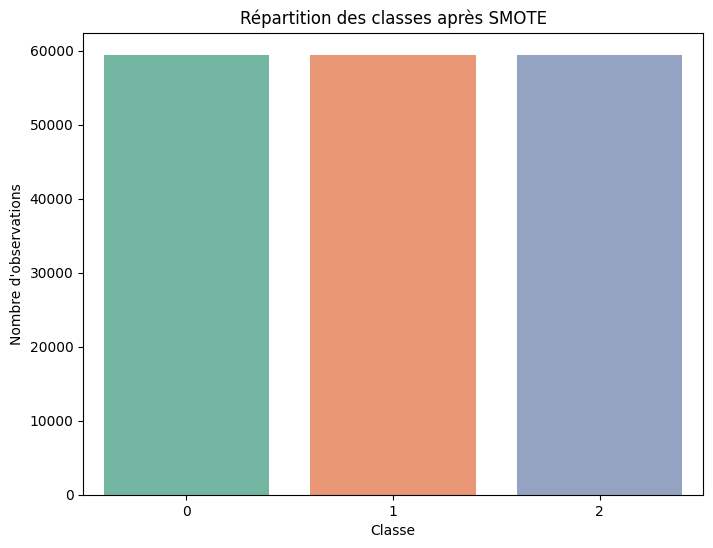

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

# données rééchantillonnées
df2 = pd.DataFrame(x, columns=x.columns)  
df2['class'] = y  

# Visualisation de la distribution des classes après SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df2, palette='Set2')
plt.title('Répartition des classes après SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()


- Normlaisation des données

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

Nous normalisons les données afin de mettre toutes les caractéristiques sur la même échelle, ce qui améliore la performance et la convergence.


- Analyse PCA

Pour explorer la structure globale des données et voir s'il existe une séparation naturelle entre les classes (STAR, GALAXY, QSO), nous avons utilisé l'Analyse en Composantes Principales (PCA). Mais avant cela, nous avons normalisé les données car les variables comme le redshift et les magnitudes (u, g, r, i, z) ont des échelles différentes. 

Une fois les données normalisées, la PCA nous a permis de réduire les dimensions des données tout en gardant l'essentiel de l'information. Cela nous donne une vue d'ensemble et nous permet de visualiser si les différentes classes sont bien séparées ou si elles se mélangent dans l'espace réduit.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

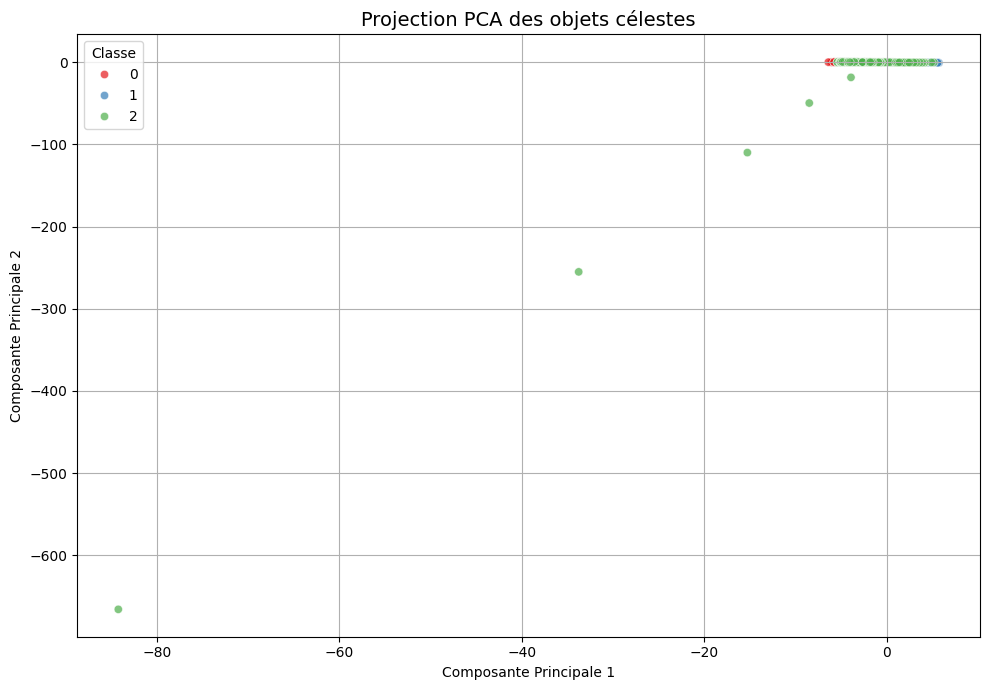

In [30]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', palette='Set1', alpha=0.7)
plt.title('Projection PCA des objets célestes', fontsize=14)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Classe')
plt.grid(True)
plt.tight_layout()
plt.show()

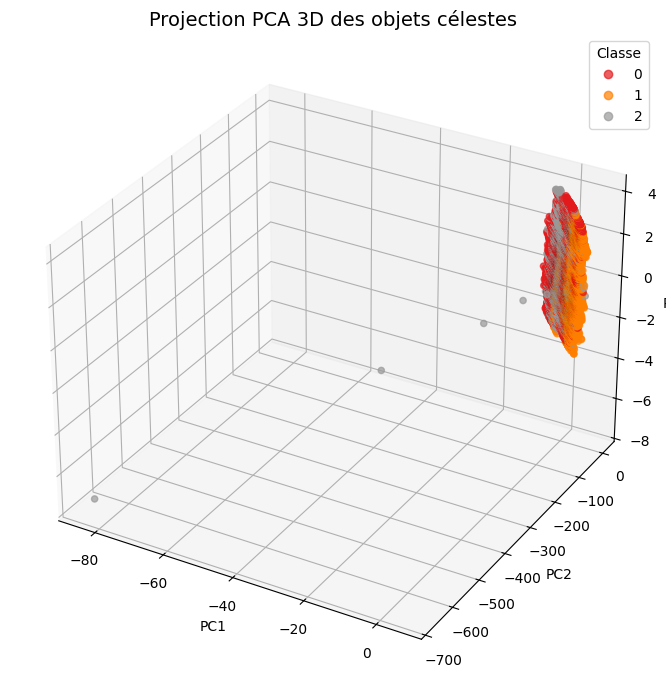

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# PCA à 3 composantes principales
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Tracé 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='Set1', alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Projection PCA 3D des objets célestes', fontsize=14)
plt.legend(*scatter.legend_elements(), title="Classe")
plt.tight_layout()
plt.show()


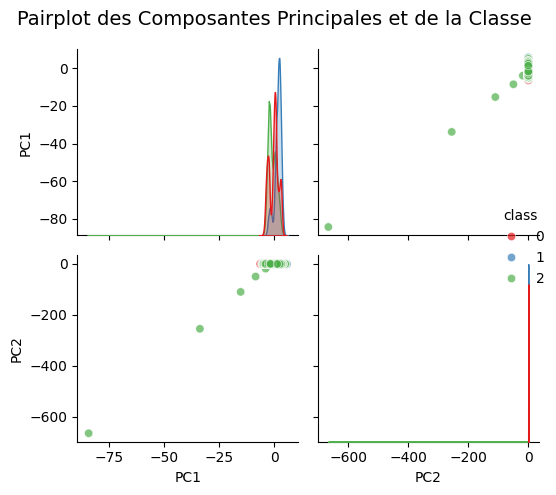

In [32]:
sns.pairplot(pca_df, hue='class', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle('Pairplot des Composantes Principales et de la Classe', fontsize=14)
plt.tight_layout()
plt.show()

Nous observons à travers les trois représentatiosn graphique ci dessus que la majorité des points sont regroupés dans la zone supérieure droite, tandis que quatre autres sont légèrement dispersés. La présence importante de vert suggère des valeurs atypiques ou extrêmes de classe 2. Les deux autres classes semblent particulièrement homogènes.

Les trois représentations graphiques ci-dessus montrent que la majorité des objets célestes sont regroupés dans la zone supérieure droite de l’espace PCA, ce qui indique une grande homogénéité au sein des trois classes. Ces objets semblent partager des caractéristiques similaires, suggérant notamment que les galaxies et les étoiles suivent des tendances comparables en termes de luminosité, couleur et redshift. En revanche, la classe 2 identifiée par la couleur verte présente une dispersion légèrement plus marquée, notamment avec 4 points dispersés dans des zones différentes de l’espace PCA. Cela pourrait indiquer la présence d’objets atypiques ou extrêmes au sein de cette classe, potentiellement liés à des phénomènes célestes rares ou à des valeurs extrêmes dans certaines variables comme le redshift.


- Séparation des données en train/test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

Nous divisos à présent le jeu en ensembles d'entraînement (80 %) et de test (20 %) tout en conservant la même proportion de classes grâce à stratify=y, et en assurant la reproductibilité avec random_state=42.

## 3. Estimation des modèles et évaluation des performances

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

### **3.1. Estimation des modèles sans paramètrage**

#### - SVM -

In [35]:
svm_model = SVC(random_state=42, kernel='linear') 
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [52]:
# Prédictions sur l'ensemble de test
y_pred_svm = svm_model.predict(X_test)

In [53]:
# Calcul des performances
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nModèle : SVM (Support Vector Machine)")
print(f"Accuracy : {accuracy * 100:.2f}%")
print("Classification Report :\n", classification_report(y_test, y_pred_svm))

#Calcul F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1 Score : {f1:.2f}")


Modèle : SVM (Support Vector Machine)
Accuracy : 96.62%
Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11889
           1       0.97      0.94      0.96     11889
           2       0.99      1.00      0.99     11889

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

F1 Score : 0.97


<Figure size 600x500 with 0 Axes>

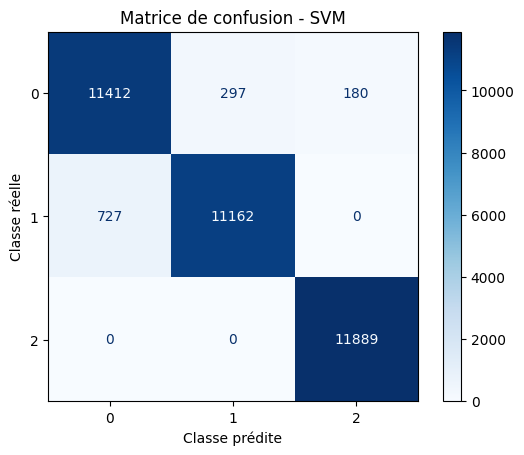

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion - SVM")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


#### - Random Forest -

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# Prédictions sur le jeu de test
y_pred_rf = rf_clf.predict(X_test)

In [57]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy : {accuracy * 100:.2f}%")
print("\nClassification Report :\n", classification_report(y_test, y_pred_rf))

#calcul F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f"F1 Score : {f1:.2f}")


Accuracy : 98.39%

Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     11889
           1       0.99      0.97      0.98     11889
           2       0.99      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667

F1 Score : 0.98


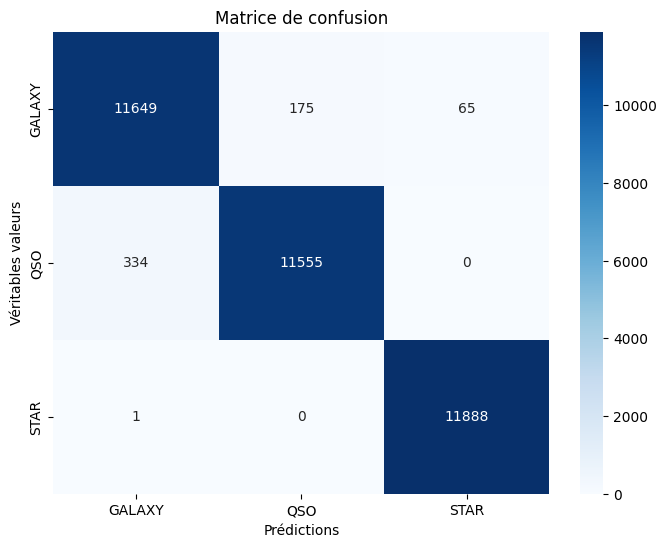

In [58]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

#matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.show()


#### - XGBoost Classifier -

In [59]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [60]:
y_pred_xgb = xgb_clf.predict(X_test)

In [61]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy : {accuracy * 100:.2f}%")
print("\nClassification Report :\n", classification_report(y_test, y_pred_xgb))

#calcul F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"F1 Score : {f1:.2f}")

Accuracy : 98.24%

Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     11889
           1       0.98      0.97      0.98     11889
           2       0.99      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667

F1 Score : 0.98


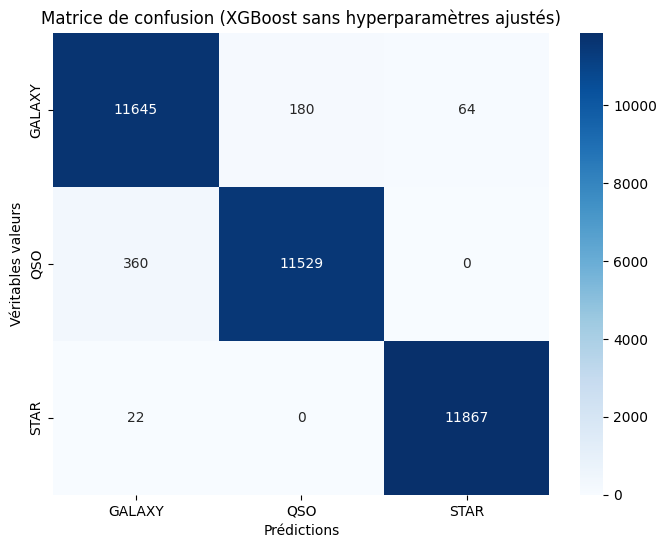

In [62]:
# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (XGBoost sans hyperparamètres ajustés)')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.show()


#### - Regression logistique -

In [63]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [64]:
# Prédiction
y_pred_log = logreg.predict(X_test)

In [65]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy : {accuracy * 100:.2f}%")
print("\nClassification Report :\n", classification_report(y_test, y_pred_log))

#calcul F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_log, average='weighted')
print(f"F1 Score : {f1:.2f}")

Accuracy : 95.93%

Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     11889
           1       0.97      0.93      0.95     11889
           2       0.97      1.00      0.98     11889

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667

F1 Score : 0.96


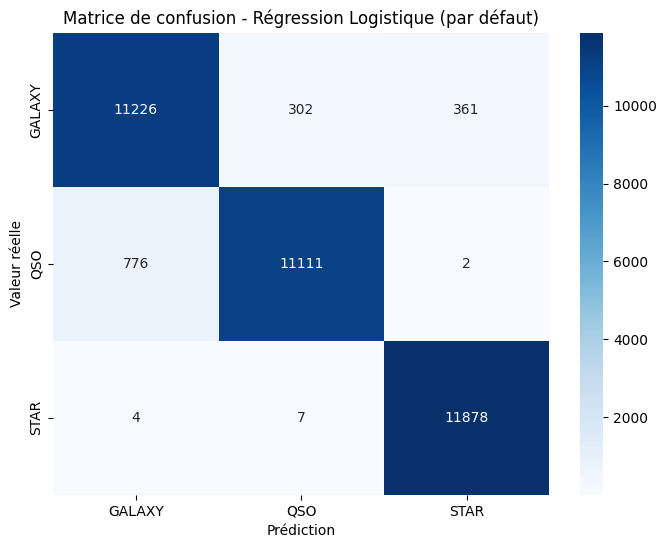

In [66]:
# Matrice de confusion
conf_matrix_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion - Régression Logistique (par défaut)')
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.show()

### **3.2. Estimation des modèles avec paramètrage**

#### - SVM avec hyperparamètres ajustés -

In [67]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Entraînement du modèle
svm_clf = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_clf.fit(X_train, y_train)

SVC(C=1, random_state=0)

In [68]:
# Prédictions
y_pred_svm2 = svm_clf.predict(X_test)

In [69]:
# Calcul des performances
accuracy = accuracy_score(y_test, y_pred_svm2)
print(f"Accuracy : {accuracy:.3f}")
print("Classification Report :\n", classification_report(y_test, y_pred_svm2))

# Calcul du F1 score
f1 = f1_score(y_test, y_pred_svm2, average='weighted')
print(f"F1 Score : {f1:.3f}")

Accuracy : 0.968
Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     11889
           1       0.98      0.95      0.97     11889
           2       0.97      1.00      0.98     11889

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

F1 Score : 0.968


<Figure size 600x500 with 0 Axes>

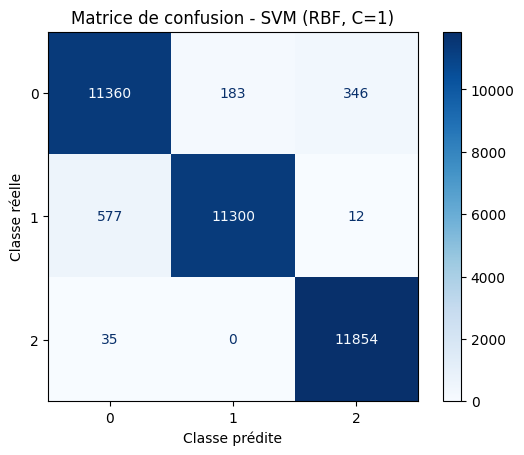

In [70]:
#matrice conf
cm = confusion_matrix(y_test, y_pred_svm2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion - SVM (RBF, C=1)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


#### - Random Forest avec hyperparamètres ajustés -

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid,
                              scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [14]:
# Meilleur modèle
best_rf_modele = grid_search_rf.best_estimator_
y_pred_rf2 = best_rf_modele.predict(X_test)

# Évaluation
from sklearn.metrics import classification_report, accuracy_score
print("Meilleurs hyperparamètres :", grid_search_rf.best_params_)
print("Accuracy :", accuracy_score(y_test, y_pred_rf2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf2, target_names=le.classes_))

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy : 0.9854206970028317

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     11889
         QSO       0.99      0.97      0.98     11889
        STAR       1.00      1.00      1.00     11889

    accuracy                           0.99     35667
   macro avg       0.99      0.99      0.99     35667
weighted avg       0.99      0.99      0.99     35667



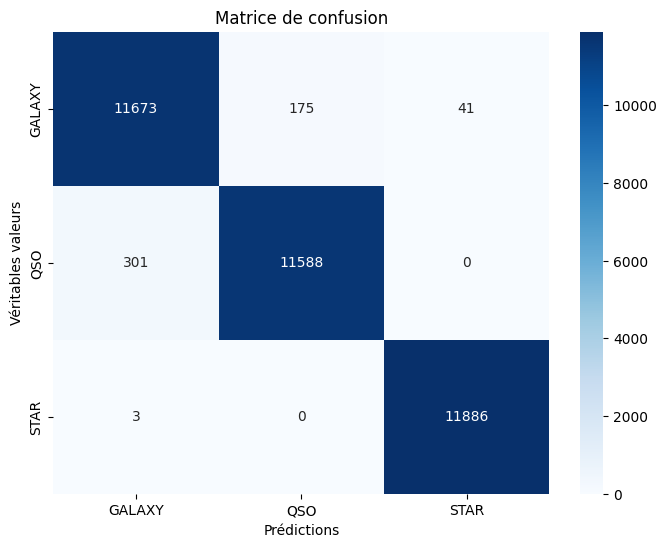

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf2)

# Visualiser la matrice de confusion avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.show()

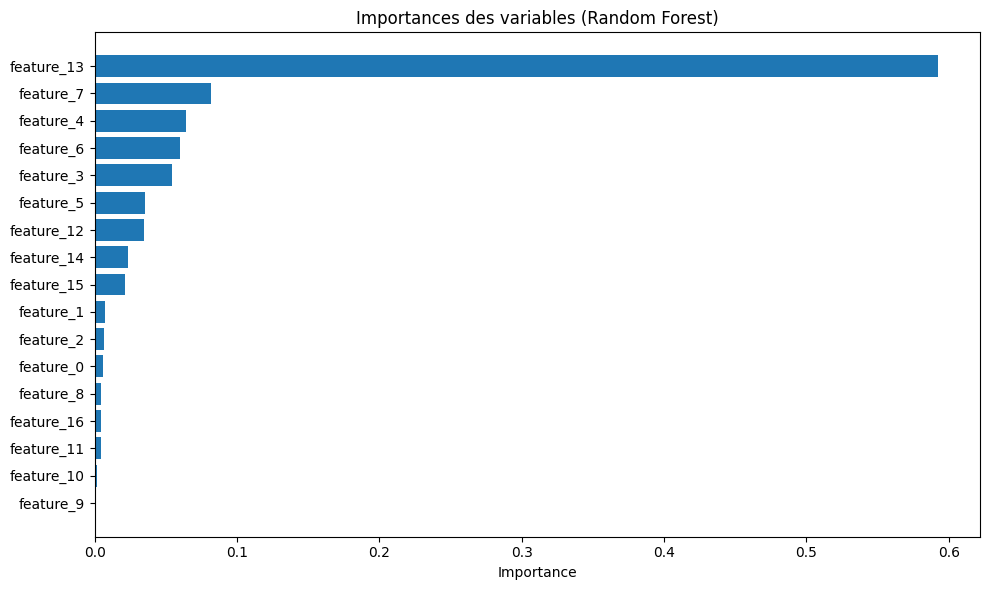

In [17]:

feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]

importances = best_rf_modele.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Importance")
plt.title("Importances des variables (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### - XGBoost Classifier avec hyperparamètres ajustés -

In [ ]:
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,
                               scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner

In [ ]:
y_pred_xgb2 = best_xgb.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Meilleurs hyperparamètres :", grid_search_xgb.best_params_)
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))


Meilleurs hyperparamètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy : 0.982560910645695

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     11889
         QSO       0.98      0.97      0.98     11889
        STAR       0.99      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667



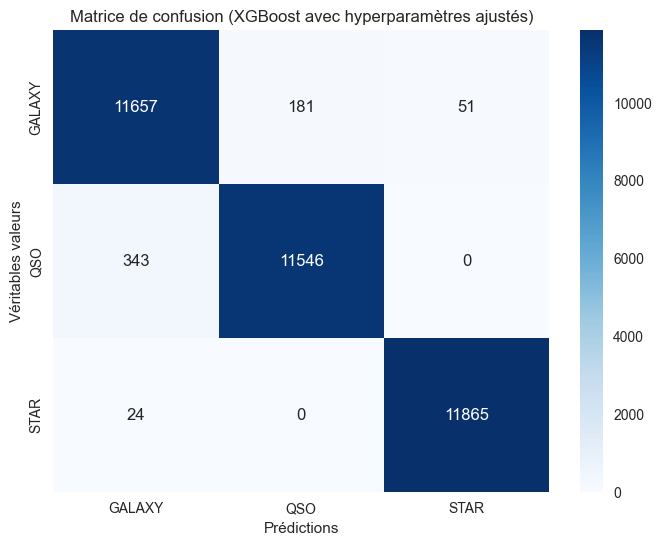

In [ ]:
# Calculer la matrice de confusion
conf_matrix_tuned = confusion_matrix(y_test, y_pred_xgb2)

# Visualiser la matrice de confusion avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (XGBoost avec hyperparamètres ajustés)')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.show()

#### - Regression Logistique avec hyperparamètres ajustés -

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],         
    'solver': ['lbfgs'],             
    'penalty': ['l2'],              
    'class_weight': [None, 'balanced']
}

logreg = LogisticRegression(max_iter=1000, random_state=42)

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Meilleur modèle et score
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure précision :", grid_search.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres : {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleure précision : 0.9649185585396687


In [ ]:
best_logreg = grid_search.best_estimator_

# Prédictions sur le jeu de test
y_pred_log_tuned = best_logreg.predict(X_test)

In [ ]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_pred_log_tuned)
print(f"Accuracy : {accuracy * 100:.2f}%")
print("\nClassification Report :\n", classification_report(y_test, y_pred_log_tuned))

#calcul F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_log_tuned, average='weighted')
print(f"F1 Score : {f1:.2f}")

Accuracy : 96.48%

Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11889
           1       0.97      0.94      0.95     11889
           2       0.98      1.00      0.99     11889

    accuracy                           0.96     35667
   macro avg       0.97      0.96      0.96     35667
weighted avg       0.97      0.96      0.96     35667

F1 Score : 0.96


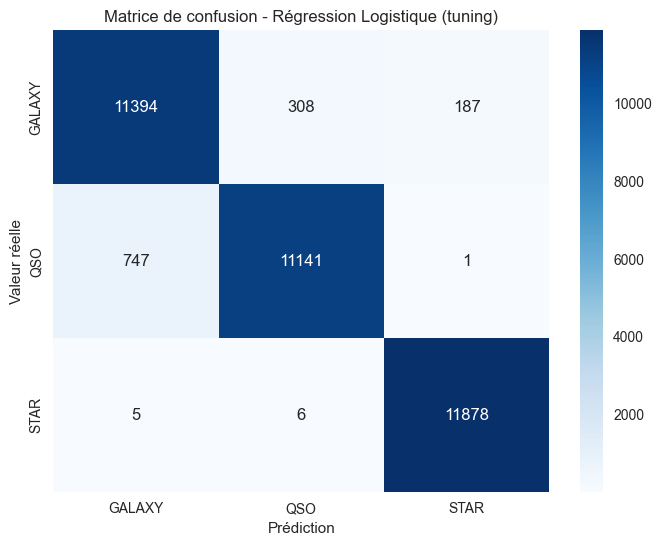

In [ ]:
# Matrice de confusion
conf_matrix_log_tuned = confusion_matrix(y_test, y_pred_log_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion - Régression Logistique (tuning)')
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.show()


### **3.3. Sélection de variables**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Appliquer SelectKBest avec ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=13) 
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selection = x.columns[selector.get_support()]
print(f"Variables sélectionnées : {list(selection)}")

Variables sélectionnées : ['obj_ID', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'spec_obj_ID', 'redshift', 'plate', 'MJD', 'fiber_ID']


/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


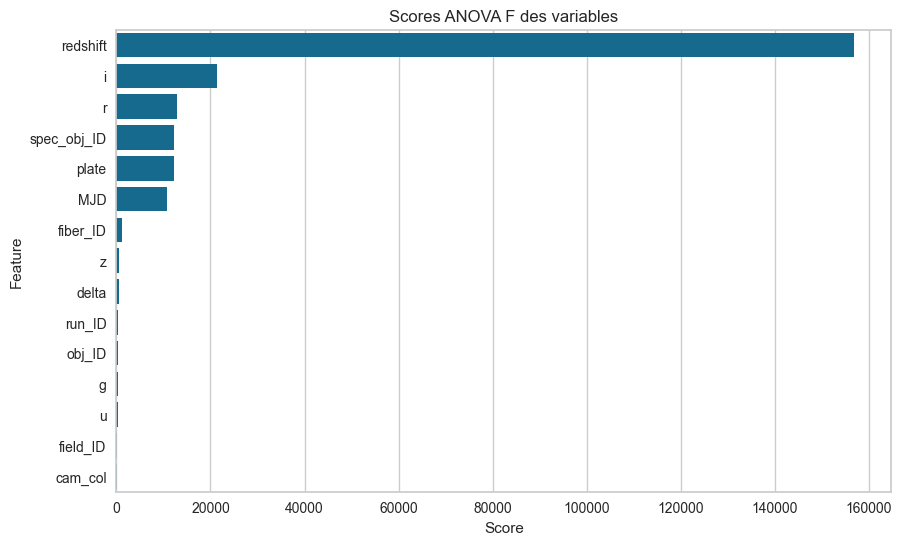

In [ ]:
feature_scores = pd.DataFrame({
    'Feature': x.columns, 
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title("Scores ANOVA F des variables")
plt.show()


### **3.4. Estimation des modèles sans paramètrage avec sélection de variables**

#### - SVM -

In [47]:
from sklearn.svm import SVC

svm_model = SVC(random_state=42)
svm_model.fit(X_train_selected, y_train)
y_pred_svm = svm_model.predict(X_test_selected)

print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM
Accuracy: 0.9680096447696751
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11889
           1       0.98      0.95      0.97     11889
           2       0.97      1.00      0.98     11889

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667



#### - Random Forest -

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)

print("\n Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest
Accuracy: 0.983822581097373
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11889
           1       0.98      0.97      0.98     11889
           2       1.00      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667



#### - XGBoost -

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

print("\n XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:35:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost
Accuracy: 0.9820282053438752
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11889
           1       0.98      0.97      0.98     11889
           2       0.99      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667



#### - Regression Logistique -

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_selected, y_train)
y_pred_logreg = logreg_model.predict(X_test_selected)

print("\n Régression Logistique")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))



 Régression Logistique
Accuracy: 0.9596265455463033
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11889
           1       0.97      0.94      0.95     11889
           2       0.97      1.00      0.98     11889

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667



### **3.5. Estimation des modèles avec paramètrage avec sélection de variables**

#### - SVM avec hyperparamètres ajustés -

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_selected, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_selected)

print(" SVM (optimisé)")
print("Best params:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

🔹 SVM (optimisé)
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9741497743011748
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11889
           1       0.98      0.95      0.97     11889
           2       0.98      1.00      0.99     11889

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667



#### - Random Forest avec hyperparamètres ajustés -

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_selected)

print("\n Random Forest (optimisé)")
print("Best params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


 Random Forest (optimisé)
Best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.978860010654106
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11889
           1       0.98      0.97      0.97     11889
           2       0.99      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667



#### XGBoost avec hyperparamètres ajustés - 

In [ ]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_selected, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_selected)

print("\n XGBoost (optimisé)")
print("Best params:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ameldahmani/anaconda3/envs/tpWebScrapping/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner


 XGBoost (optimisé)
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.9802899038326744
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11889
           1       0.98      0.96      0.97     11889
           2       1.00      1.00      1.00     11889

    accuracy                           0.98     35667
   macro avg       0.98      0.98      0.98     35667
weighted avg       0.98      0.98      0.98     35667



#### - Regression Logistique avec hyperparamètres ajustés - 

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid_logreg = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

logreg = LogisticRegression(max_iter=1000, random_state=42)
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train_selected, y_train)

best_logreg = grid_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_selected)

print("\n Régression Logistique (optimisée)")
print("Best params:", grid_logreg.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))



 Régression Logistique (optimisée)
Best params: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9648414500799058
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11889
           1       0.97      0.94      0.95     11889
           2       0.98      1.00      0.99     11889

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667



### **4. Choix du meilleur modèle**

- Comparaison des modèles

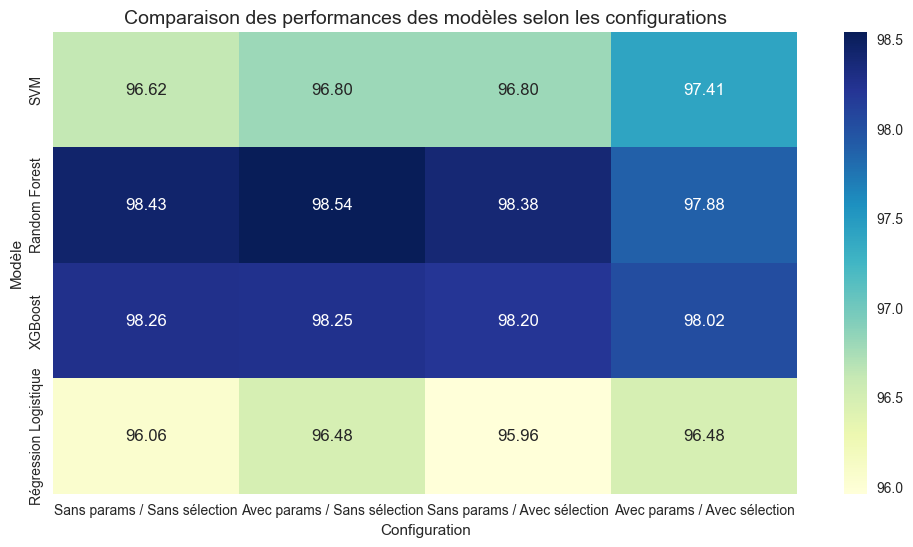

In [ ]:
import pandas as pd

# Résumé des performances
data = {
    'Modèle': ['SVM', 'Random Forest', 'XGBoost', 'Régression Logistique'],
    'Sans tuning+Sans sélection': [96.62, 98.43, 98.26, 96.06],
    'Tuning seul': [96.8, 98.54, 98.25, 96.48],
    'Sélection seule': [96.80, 98.38, 98.20, 95.96],
    'Tuning+Sélection': [97.41, 97.88, 98.02, 96.48]
}

results_df = pd.DataFrame(data)
results_df.set_index('Modèle', inplace=True)

# Affichage du tableau
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Comparaison des performances des modèles selon les configurations", fontsize=14)
plt.ylabel("Modèle")
plt.xlabel("Configuration")
plt.show()


Au terme de cette étude comparative sur des données astronomiques classifiées en trois catégories (GALAXY, STAR, QSO), plusieurs modèles de machine learning ont été testés selon différentes configurations et ont donnés les résultats suivants (accuracy) :

| Modèle                | Sans tuning, sans sélection | Tuning seul | Sélection seule | Tuning + Sélection |
|----------------------|-----------------------------|------------------|-----------------------|--------------------|
| SVM                  | 96.62%                      | 96.80%           | 96.80%                | 97.41%         |
| Random Forest        | **98.43%**                  | **98.54%**       | **98.38%**               | 97.88%             |
| XGBoost              | 98.26%                      | 98.25%           | 98.20%                | **98.02%**             |
| Régression Logistique| 96.06%                      | 96.48%           | 95.96%                | 96.48%             |


Quatre configurations ont été comparées : 
- (1) sans tuning ni sélection de variables
- (2) avec tuning seul
- (3) avec sélection de variables seule
- (4) avec tuning et sélection de variables

Dans leur configuration par défaut, les modèles Random Forest et XGBoost se sont immédiatement démarqués par leurs performances exceptionnelles, atteignant respectivement 98.43% et 98.26% d’accuracy. Ces modèles d'ensemble sont naturellement robustes aux variables peu informatives et aux déséquilibres de classe. À l'inverse, la régression logistique et le SVM affichaient des scores très perfromant également mais plus modestes que les deux premiers (autour de 96%), ce qui souligne leur sensibilité aux configurations par défaut et à la structure des données.

L’introduction d’un réglage d’hyperparamètres (GridSearchCV) a permis d’améliorer la performance de tous les modèles, en particulier celle du SVM, qui est passé à 96.80%, et du Random Forest, qui a atteint un pic à 98.54%. Cela met en évidence l'importance du tuning, notamment pour les modèles qui reposent sur des décisions binaires ou des marges comme le SVM. La régression logistiquea été légèrement moins performante que les autres, mais a gagne en précision avec une régularisation et un solveur bien choisis.

La sélection de variables via la méthode SelectKBest a également été explorée, permettant de ne conserver que les 13 variables les plus informatives selon le test ANOVA. Cette réduction de dimension s’est avérée efficace, notamment pour le SVM et XGBoost qui ont conservé, voire légèrement amélioré, leurs performances. Pour la régression logistique, on a toutefois observé une légère baisse de précision, signe que ce modèle est légèrement plus sensible à la perte d'information dans des données complexes.

La meilleure configuration observée pour chaque modèle combine tuning des hyperparamètres et sélection de variables. Le SVM atteint alors 97.41%, montrant qu’il est capable de rivaliser avec les meilleurs modèles à condition d’être bien configuré. XGBoost et Random Forest conservent leurs performances très élevées (respectivement 98.02% et 97.88%) tout en bénéficiant de modèles plus compacts grâce à la sélection des variables. La régression logistique, quant à elle, atteint un plafond à 96.48%, ce qui confirme son utilité comme modèle de base de comparaison, mais aussi ses limites dans des cas plus complexes.

### Explicabilité par individu sur le modèle RF tuné

In [18]:
import pandas as pd
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)

if X_train.columns is None or isinstance(X_train.columns[0], int):
    X_train.columns = [f"feature_{i}" for i in range(X_train.shape[1])]

importances = best_rf_modele.feature_importances_
top_indices = np.argsort(importances)[::-1][:3]
top_features = X_train.columns[top_indices].tolist()
print("Variables sélectionnées pour ICE :", top_features)


Variables sélectionnées pour ICE : ['feature_13', 'feature_7', 'feature_4']


In [55]:
top_features_real_names = x.columns[top_indices].tolist()
print("Noms des features sélectionnées pour ICE : ", top_features_real_names)

Noms des features sélectionnées pour ICE :  ['redshift', 'z', 'g']


- Individual Conditional Expectation (ICE)

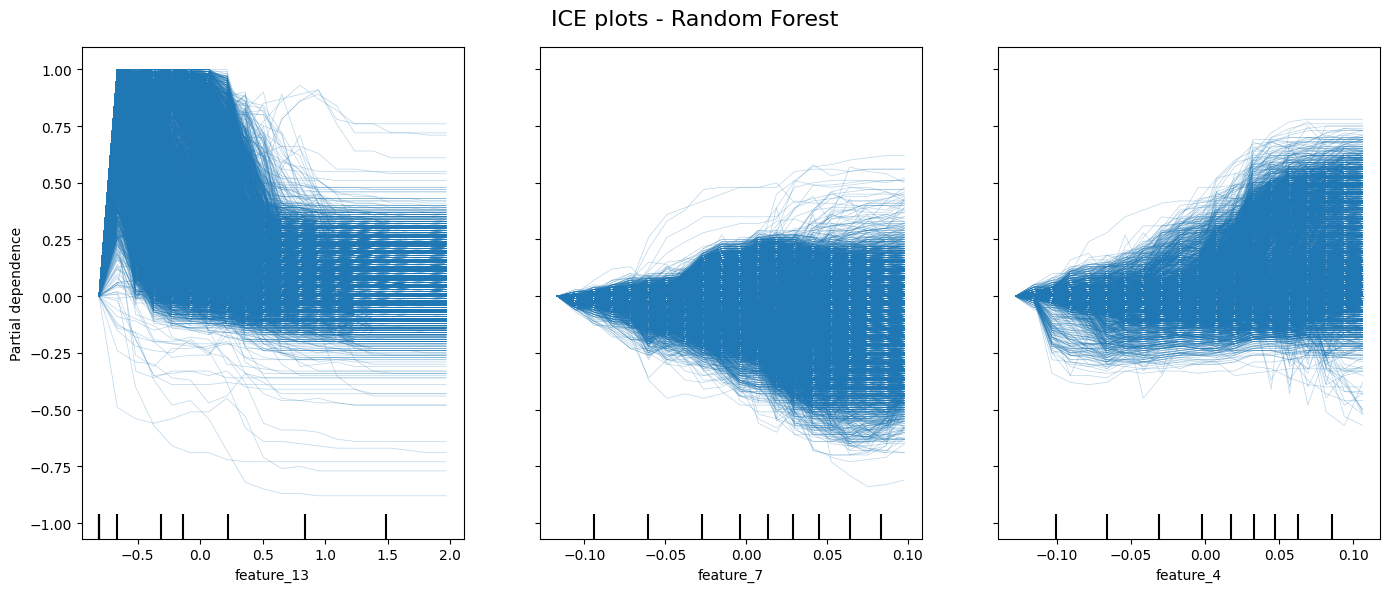

In [54]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# ICE 
_, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(best_rf_modele,
                                        X_train,
                                        features=top_features,
                                        kind="individual",
                                        ax=ax,
                                        grid_resolution=20,
                                        subsample=0.05, 
                                        centered=True,
                                        n_cols=3,
                                        target=0)  # première classe
plt.suptitle("ICE plots - Random Forest", fontsize=16)
plt.tight_layout()
plt.show()


Les features 13, 7 et 4 correspondent respectivement aux variables 'redshift', 'z', 'g'.

#feature_13 = redshift

La dépendance partielle chute brusquement vers ~0.25 lorsque redshift dépasse environ 0.
Cela indique que cette variable a une forte influence non linéaire, avec une nette séparation autour de 0.
Avant 0, la prédiction est souvent plus élevée, ce qui suggère une importance discriminante dans le modèle.

#feature_7 = z

Les courbes ICE sont plutôt symétriques autour de 0.
Faible variation → cette variable a moins d’impact ou un impact très localisé.

#feature_4 = g

Augmentation progressive de la dépendance avec la valeur g.
Cela indique un effet positif modéré, cohérent mais moins tranché que redshift.

Pour conclure ce graphiques montrent que le modèle Random Forest s’adapte de manière non linéaire, 
avec des comportements individuels différents pour chaque observation.

- Local surogate (LIME)

In [56]:
import lime
import lime.lime_tabular
import numpy as np

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)

if X_train.columns is None or isinstance(X_train.columns[0], int):
    X_train.columns = [f"feature_{i}" for i in range(X_train.shape[1])]

feature_names = X_train.columns.tolist()
class_names = le.classes_.tolist()  

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    verbose=True,
    mode='classification'
)

i = 3018

exp = explainer.explain_instance(
    X_train.iloc[i].values,
    best_rf_modele.predict_proba,
    num_features=5
)



Intercept 0.3192170234546139
Prediction_local [0.46702583]
Right: 0.0


L'intercept de 0.319 indique que la probabilité de base pour cette classe, sans tenir compte des caractéristiques spécifiques de l'exemple, est de 31.9%. C'est la probabilité initiale avant toute influence des features (on va pouvoir voir cela plus en détail ci-dessous)

La prédiction locale de 0.467 signifie qu'après avoir pris en compte les caractéristiques de cet exemple, le modèle prédit que cet exemple a une probabilité de 46.7% d'appartenir à la classe cible.

Le fait que 'Right' soit 0 indique que la prédiction du modèle n'est pas correcte par rapport à la classe cible. Cela suggère que malgré l'ajustement des prédictions en fonction des caractéristiques, le modèle n'a pas correctement

In [57]:
#Afficher lime explainer in notebook
exp.show_in_notebook(show_table=True)

Le redshift est de 0.03, ce qui le place dans une zone intermédiaire et tend vers les QSO. Un redshift légèrement positif, comme celui observé, est caractéristique de certains QSO, ce qui est donc cohérent avec cette classification.

Pour z = 0.04, situé dans la plage de [0.01 ; 0.06], cela indique une légère tendance vers les QSO.

Enfin, la valeur de g = 0.13 (supérieure à 0.05) oriente davantage vers une classification en tant que GALAXIE.

- SHAP

<Figure size 640x480 with 0 Axes>

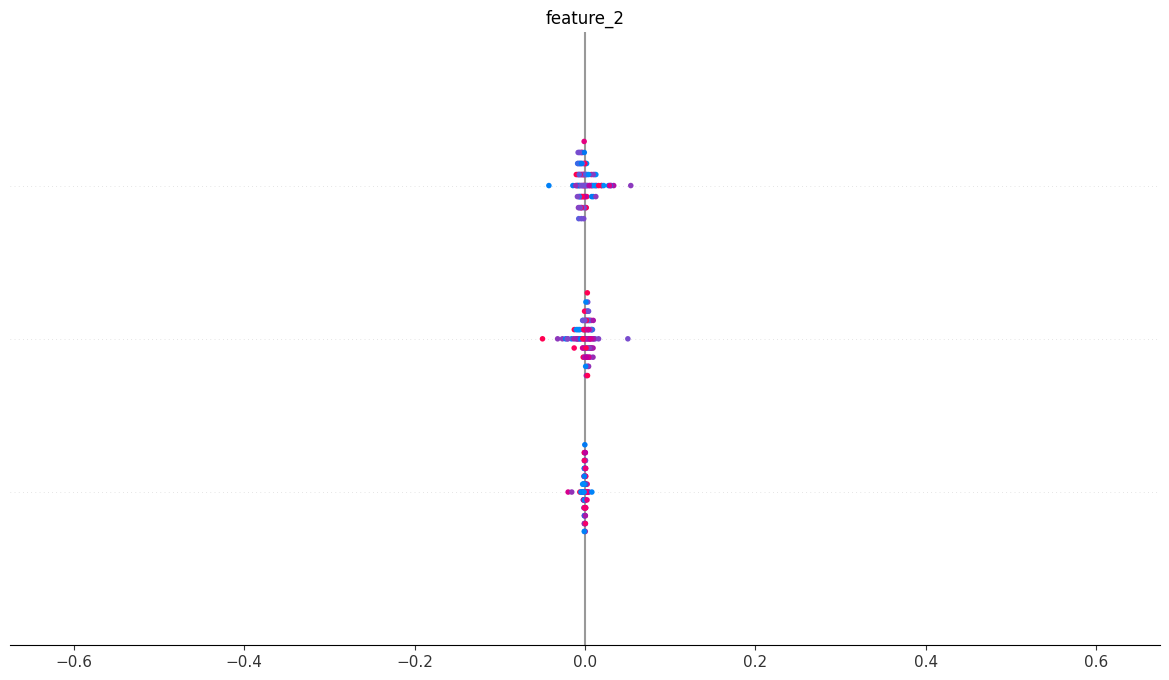

In [58]:
import shap

explainer = shap.TreeExplainer(best_rf_modele)

X_sample = X_train.iloc[1:100]

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns)


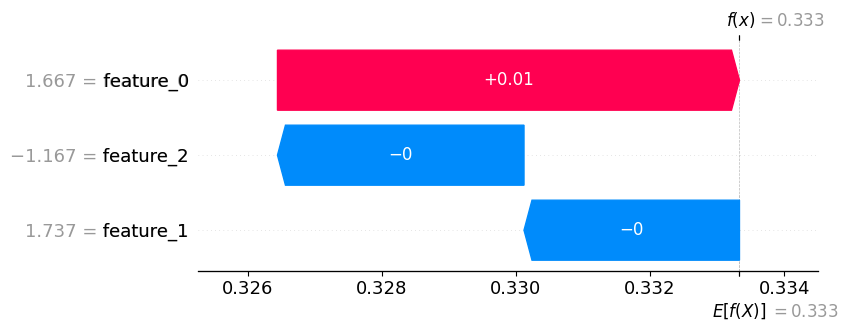

In [59]:
shap.initjs()

explanation = shap.Explanation(values=shap_values[0][1], 
							   base_values=explainer.expected_value[0], 
							   data=X_sample.iloc[1])

shap.waterfall_plot(explanation)

L'histogramme des valeurs de SHAP montre une variation de la prédiction entre 0.326 et 0.334, indiquant que la prédiction finale  se situe dans cette plage. Cette variation reflète l'impact des différentes caractéristiques sur la prédiction du modèle.

Feature 1 (1.737) : Cette caractéristique avec une valeur de 1.737. Son impact est positif, indiquant qu'elle pousse la prédiction vers une classe spécifique, mais elle n'a pas d'impact majeur au vu du 0 présent.

Feature 2 (-1.167) : Cette caractéristique a un effet négatif sur la prédiction, avec une valeur de -1.167. Elle réduit la probabilité de l'objet d'appartenir à une classe, ce qui indique qu'elle agit dans le sens opposé aux autres caractéristiques, mais elle n'a pas d'impact majeur au vu du 0 présent.

Feature 0 (1.667, impact de +0.01) : Cette caractéristique est fortement influente, avec une valeur de 1.667. Son impact est positif avec +.01, indiquant qu'elle pousse la prédiction vers une classe spécifique, plus que les autres, meme si cela reste leger


Les caractéristiques photométriques et spectroscopiques, telles que les magnitudes dans les différentes bandes (u, g, r, i, z), et le redshift (décalage vers le rouge) jouent sans doute plus un rôle, car objet id, alpha et delta ne jouent pas forcement un role cles au vu des résulats dans la classification des objets célestes.

Les résultats de l'analyse SHAP montrent que certaines caractéristiques (comme Feature 1) alpha et delta n'ont pas d'impact majeur sur la prédiction , et la features 0 soit objet id, malgrés que cela soit plus élevée, cela reste trés faible.

In [ ]:
print(x.columns[[0, 1, 2]])

Index(['obj_ID', 'alpha', 'delta'], dtype='object')


Les features 0, 1 et 2 sont respectivement 'obj_ID', 'alpha' et 'delta'.

In [63]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

Le graphique Force Plot SHAP nous paraissait important, car il illustre une visualisation qui permet d'expliquer comment chaque caractéristique d'une instance donnée influence la prédiction du modèle. Il met en évidence l'impact de chaque caractéristique sur la prédiction, en comparant la prédiction finale à la valeur de base, c’est-à-dire la moyenne des prédictions avant de considérer les données spécifiques de l’instance. Les contributions de chaque caractéristique sont représentées sous forme de barres colorées et orientées : les flèches rouges indiquent une contribution positive (augmentation de la probabilité de la classe cible), tandis que les flèches bleues montrent une contribution négative (diminution de cette probabilité). Cela permet d’avoir une vue claire et interprétable de la manière dont le modèle arrive à sa décision pour une instance donnée.

L’explication SHAP montre que les coordonnées célestes et l’identifiant de l’objet ont un impact très limité sur la prédiction, ce que l’on constate par l’étroitesse des courbes rouges et bleues les représentant. Cela suggère que le modèle ne s’appuie pas fortement sur la position dans le ciel ou l’ID pour classer un objet comme GALAXY, STAR ou QSO, ce qui confirme également les analyses précédentes. Le modèle se base plutôt sur d'autres variables plus discriminantes comme le redshift ou les magnitudes photométriques.

### 5. **Conclusion**

La meilleure performance a été obtenue par Random Forest avec un score de 98.54% après tuning des hyperparamètres seul sur le jeu de données complet.

Les modèles SVM, Random Forest, et XGBoost ont tous montré une excellente aptitude à classer les objets célestes en fonction de leurs caractéristiques spectroscopiques et photométriques. Cette capacité de prédiction est d'autant plus pertinente lorsque l'on considère la nature des données astronomiques, où des objets rares ou extrêmes comme les quasars peuvent constituer des "outliers" tout en étant parfaitement valides. L'utilisation de modèles robustes, capables de gérer ces outliers, est donc cruciale dans ce contexte.

En conclusion, même si la sélection de variables n'a pas significativement amélioré les résultats dans ce cas particulier, les modèles sont performants et prêts pour des applications pratiques dans la classification d'objets célestes à partir des données du SDSS.

--- 
DAHMANI Amel et ONNO Lilou